# Neural Networks Fundamentals - Mini BatchGradient Descent
This project is part of the (cannot explicitly name it) course at TU Eindhoven. It focuses on the fundamentals of neural networks, with an emphasis on implementing a Multi-Layer Perceptron (MLP) to classify digits from the MNIST dataset. You will work with fully-connected layers, activation functions (ReLU and Sigmoid), and mini-batch SGD with cross-entropy loss. The project also involves analyzing the model’s performance, calculating trainable parameters, and experimenting with different loss functions such as Cross-Entropy, Dice, and Focal Loss to enhance accuracy.

### Running Code
Using course provided "experiments" environment is recommended.

### Variables explanation
- **W1**: Weights for the first layer (input to hidden layer)
- **b1**: Bias for the first layer
- **W2**: Weights for the second layer (hidden to output layer)
- **b2**: Bias for the second layer
- **A1**: Activation of the first layer (output after applying activation function to Z1)
- **A2**: Output of the network (after applying softmax activation function to Z2)
- **Z1**: Linear transformation for the first layer (W1.dot(values) + b1)
- **Z2**: Linear transformation for the second layer (W2.dot(A1) + b2)
- **m**: Number of training examples (samples in the training set)
- **n**: Number of features (including labels)
- **values**: Input features (e.g., pixel values for MNIST images)
- **labels**: Ground truth labels (e.g., corresponding digit labels for MNIST images)
- **dW1**: Gradient of the weights for the first layer
- **db1**: Gradient of the bias for the first layer
- **dW2**: Gradient of the weights for the second layer
- **db2**: Gradient of the bias for the second layer
- **alpha**: Learning rate (step size for weight updates)

### Results

MBGD, epochs: 200, alpha: 0.1, activation: sigmoid, batch size: 64\
training time: 620s, test accuracy: 0.933, test loss: 0.237\
comment: Why is validation loss smaller than test? Wrong loss calculation (without rounding up the denominator)\
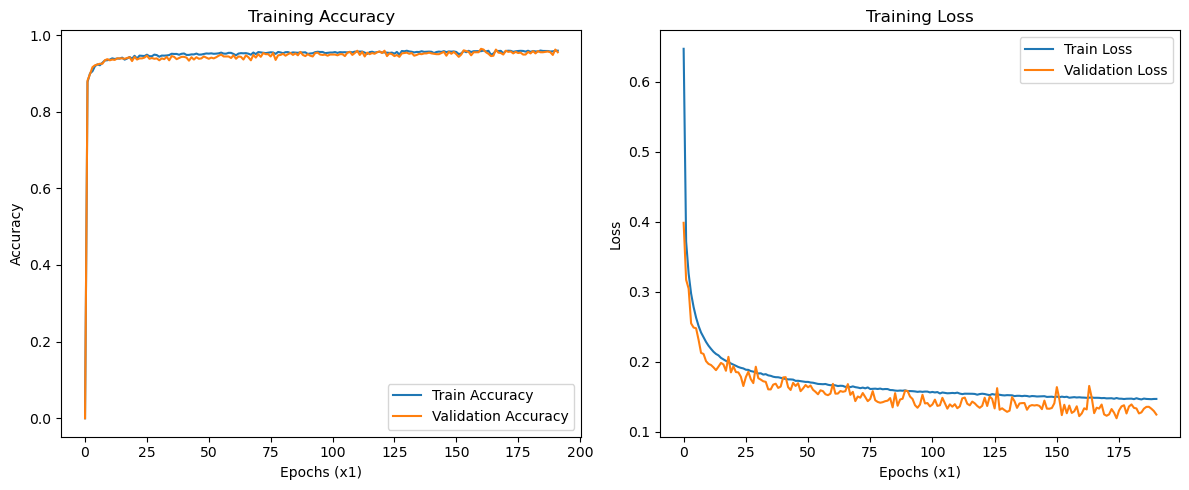
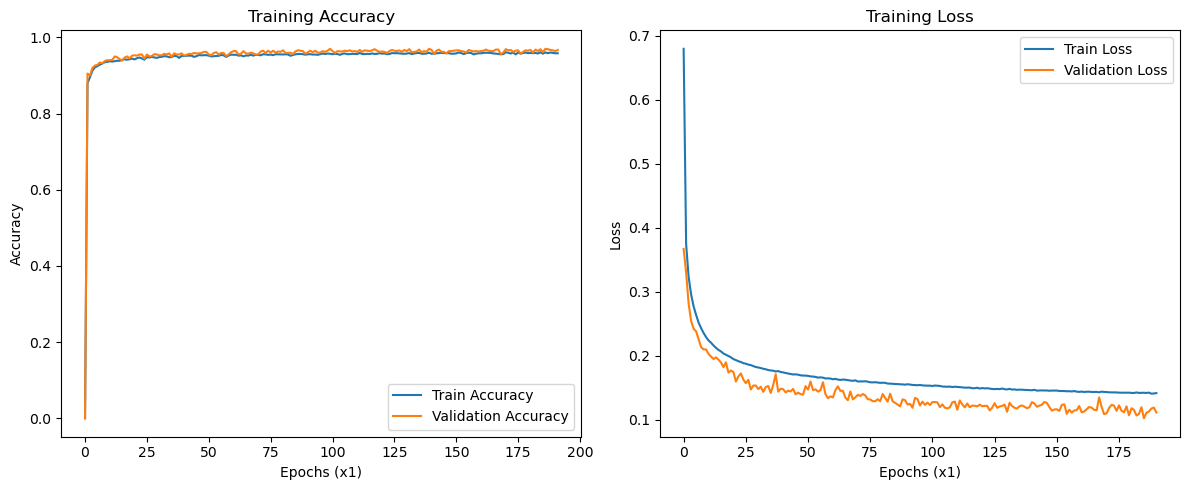

MBGD, epochs: 200, alpha: 0.1, activation: sigmoid, batch size: 1024\
training time: -s, test accuracy: 0.933, test loss: 0.257\
comment: Solved train loss calculation
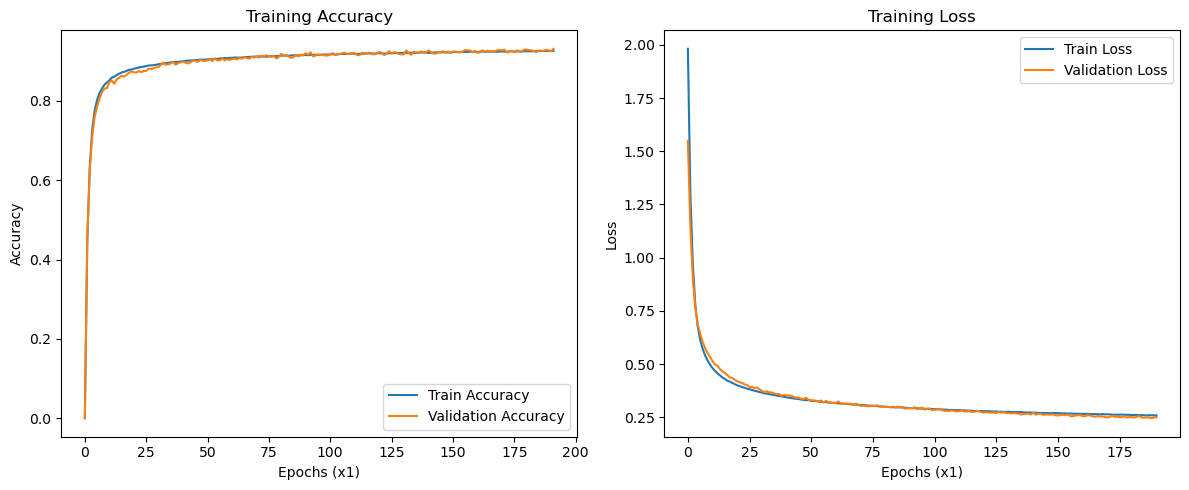

MBGD, epochs: 200, alpha: 0.1, activation: sigmoid, batch size: 64\
training time: 586s, test accuracy: 0.938, test loss: 0.231\
comment: Solved train loss calculation
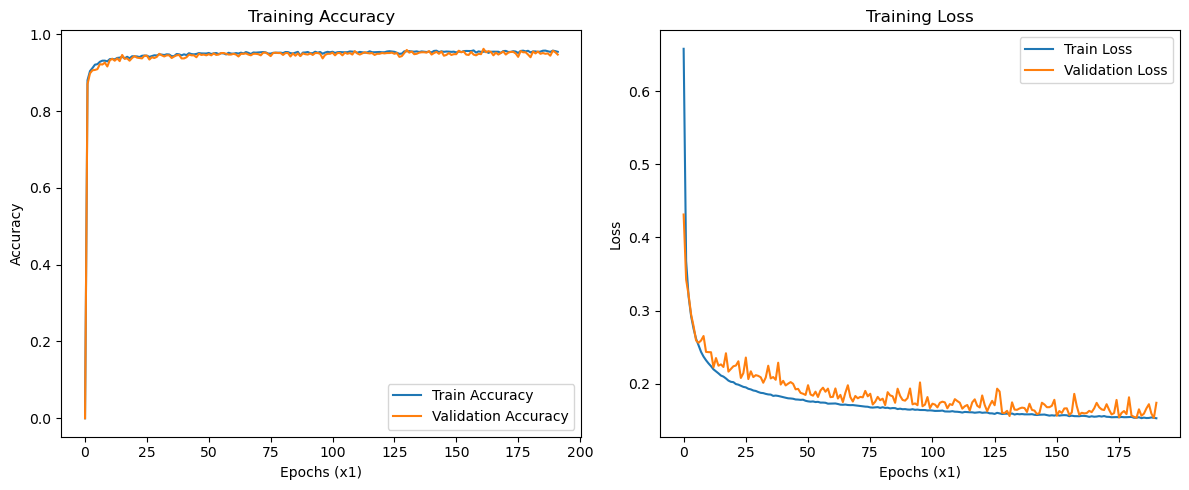

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math

In [13]:
DEBUG = True # Used to display additional information during program execution
TEST_SIZE = 1000
VALIDATION_SIZE = 1000
ALPHA = 0.1
EPOCHS = 200
BATCHSIZE = 64
TRAINING_UPDATES = 1 # number of epochs after which training update is printed
TRAINING_SHOW_UPDATES = 10 # number of epoch after which training plot is shown

In [14]:
def show_image(values, index):
    """
    Display image selected by index from given values matrix
    """
    image = values[:, index, None]
    image = image.reshape((28,28)) * 255
    plt.gray()
    plt.imshow(image)
    plt.show()

In [15]:
#Load dataset from a file
data = pd.read_csv('Datasets/MNIST_CSV/mnist.csv', header=None)
if DEBUG:
    print(data.head())

   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0    5    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    4    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    1    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    9    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]


n = 785
m = 70000
labels_train.shape = (68000,)
values_train.shape = (784, 68000)
labels_test.shape = (1000,)
values_test.shape = (784, 1000)


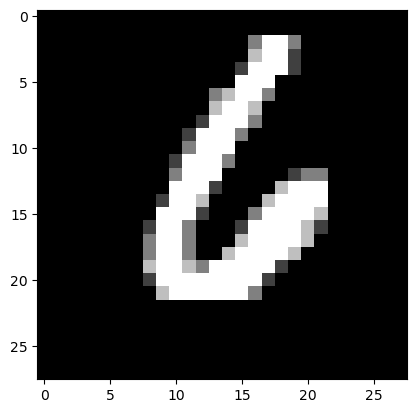

In [16]:
# Divide dataset to test, validation and train sets

data = np.array(data)
m, n = data.shape # n is amount of features including labels 

np.random.shuffle(data)

data_test = data[0:TEST_SIZE].T
labels_test = data_test[0]
values_test = data_test[1:n] / 255

data_validation = data[TEST_SIZE:(TEST_SIZE+ VALIDATION_SIZE)].T
labels_validation = data_validation[0]
values_validation = data_validation[1:n] / 255

data_train = data[(TEST_SIZE+VALIDATION_SIZE):m].T
labels_train = data_train[0]
values_train = data_train[1:n] / 255

if DEBUG:
    print("n =",n)
    print("m =",m)
    print("labels_train.shape =",labels_train.shape)
    print("values_train.shape =",values_train.shape)
    print("labels_test.shape =",labels_test.shape)
    print("values_test.shape =",values_test.shape)
    show_image(values_train, 1)

In [17]:
def init_params():
    """Initialize NN weights and biases"""
    
    W1 = np.random.rand(10,784) - 0.5
    b1 = np.random.rand(10,1) - 0.5

    W2 = np.random.rand(10,10) - 0.5
    b2 = np.random.rand(10,1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    """Calculate ReLu activation function"""
    return np.maximum(0, Z)

def sigmoid(Z):
    """Calculate Sigmoid activation function"""
    return 1 / (1 + np.exp(-Z))

def softmax(Z):
    """Calculate softmax of given vector Z"""
    Z -= np.max(Z, axis=0)
    A = np.exp(Z) / np.sum(np.exp(Z), axis=0)
    return A

def forward_propagation(W1, b1, W2, b2, values):
    """Pass through the NN input->output"""
    Z1 = W1.dot(values) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def one_hot(labels, num_classes=10):
    """Perform one-hot encoding for a batch of labels"""
    one_hot_labels = np.zeros((num_classes, labels.size))
    one_hot_labels[labels, np.arange(labels.size)] = 1
    return one_hot_labels

def deriv_ReLU(Z):
    """Derivative of ReLU activation function"""
    return Z > 0

def deriv_sigmoid(Z):
    """Calculate derivative of sigmoid activation function"""
    return sigmoid(Z) * (1 - sigmoid(Z))
    
def back_propagation(Z1, A1, Z2, A2, W2, values, labels):
    """Perform back propagation through NN output->input"""

    # Calculate output error compared to one hot labels
    one_hot_labels = one_hot(labels)
    dZ2 = A2 - one_hot_labels

    # Calculate gradients for weights in second layer
    dW2 = 1 / BATCHSIZE * dZ2.dot(A1.T)
    db2 = 1 / BATCHSIZE * np.sum(dZ2, 1)

    # calculate first layers error by propagating error backwards
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)

    # Calculate gradients for weights in first layer
    dW1 = 1 / BATCHSIZE * dZ1.dot(values.T)
    db1 = 1 / BATCHSIZE * np.sum(dZ1, 1)

    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    """Update NN weights and biases"""
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * np.reshape(db1, (10,1)) # reshape from single value to vector
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * np.reshape(db2, (10,1)) # reshape from single value to vector
    return W1, b1, W2, b2

In [18]:
def cross_entropy_loss(A2, one_hot_labels):
    """
    Calculate cross-entropy loss
    A2: predicted probabilities from softmax (shape: [num_classes, batch_size])
    one_hot_labels: one-hot encoded true labels (shape: [num_classes, batch_size])
    """

    log_probs = np.log(A2)

    # Calculate the loss for each example: sum of true labels * log(probabilities)
    loss_sample = -np.sum(one_hot_labels * log_probs, axis=0)

    loss = np.mean(loss_sample)
    
    return loss

In [19]:
def get_predictions(A2):
    """Use highest value from given vector for prediction"""
    return np.argmax(A2, 0)

def get_accuracy(predictions, labels):
    """Calculate accuracy based on given predictions and labels"""
    return np.sum(predictions == labels) / labels.size

def make_predictions(values, W1, b1, W2, b2):
    """Make prediction based on chosen values using given model parameters"""
    _, _, _, A2 = forward_propagation(W1,b1,W2,b2,values)
    predictions = get_predictions(A2)
    return predictions
    
def mini_batch_gradient_descent(values_train, labels_train, epochs, alpha, batch_size, values_validation, labels_validation):
    """Create a 3-layer NN and train it using mini-batch gradient descent"""
    start_time = time.time()
    W1, b1, W2, b2 = init_params()
    accuracy_validation_history = [0]
    accuracy_train_history = [0]
    loss_validation_history = []
    loss_train_history = []

    # Number of training examples
    m = values_train.shape[1]

    # Training loop
    for i in range(epochs):
        cumulative_loss_train = 0
        # Shuffle training data for each iteration
        permutation = np.random.permutation(m)
        values_train_shuffled = values_train[:, permutation]
        labels_train_shuffled = labels_train[permutation]

        # Mini-batch gradient descent
        for j in range(0, m, batch_size): # potential problem with last batch?

            # Divide into mini-batches
            batch_values = values_train_shuffled[:, j:j+batch_size]
            batch_labels = labels_train_shuffled[j:j+batch_size]

            # Forward propagation
            Z1, A1, Z2, A2 = forward_propagation(W1, b1, W2, b2, batch_values)

            # Back propagation
            dW1, db1, dW2, db2 = back_propagation(Z1, A1, Z2, A2, W2, batch_values, batch_labels)

            # Update parameters after each mini-batch
            W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)

            # Sum loss across all mini-batches
            loss_minibatch_train = cross_entropy_loss(A2, one_hot(batch_labels))
            cumulative_loss_train += loss_minibatch_train


        # Training progress
        if i % TRAINING_UPDATES == 0:
            print(f"Epoch {i} out of {epochs}")

            # Make predictions and test accuracy using validation set
            predictions_train = make_predictions(values_train, W1, b1, W2, b2)
            accuracy_train = get_accuracy(predictions_train, labels_train)

            # Calculate average loss across batches
            loss_train = cumulative_loss_train / math.ceil(m / batch_size)

            # Make predictions and test accuracy using validation set
            _, _, _, A2 = forward_propagation(W1, b1, W2, b2, values_validation)
            predictions_validation = make_predictions(values_validation, W1, b1, W2, b2)
            accuracy_validation = get_accuracy(predictions_validation, labels_validation)
            loss_validation = cross_entropy_loss(A2, one_hot(labels_validation))

            # Store training progress
            accuracy_train_history.append(accuracy_train)
            accuracy_validation_history.append(accuracy_validation)
            loss_train_history.append(loss_train)
            loss_validation_history.append(loss_validation)

            if i % TRAINING_SHOW_UPDATES == 0:
                # present training progress
                print(f"Train Accuracy: {accuracy_train:.3f}")
                print(f"Validation Accuracy: {accuracy_validation:.3f}")
                print(f"Train Loss: {loss_train:.3f}")
                print(f"Validation Loss: {loss_validation:.3f}")
                fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

                ax[0].plot(accuracy_train_history, label="Train Accuracy")
                ax[0].plot(accuracy_validation_history, label="Validation Accuracy")
                ax[0].set_title("Training Accuracy")
                ax[0].set_xlabel(f"Epochs (x{TRAINING_UPDATES})")
                ax[0].set_ylabel("Accuracy")
                ax[0].legend()

                ax[1].plot(loss_train_history, label="Train Loss")
                ax[1].plot(loss_validation_history, label="Validation Loss")
                ax[1].set_title("Training Loss")
                ax[1].set_xlabel(f"Epochs (x{TRAINING_UPDATES})")
                ax[1].set_ylabel("Loss")
                ax[1].legend()

                plt.tight_layout()
                plt.show()

    end_time = time.time()  # End the timer
    elapsed_time = end_time - start_time
    print(f"Training completed in {elapsed_time:.2f} seconds.")            

    return W1, b1, W2, b2


Epoch 0 out of 200
Train Accuracy: 0.880
Validation Accuracy: 0.880
Train Loss: 0.634
Validation Loss: 0.405


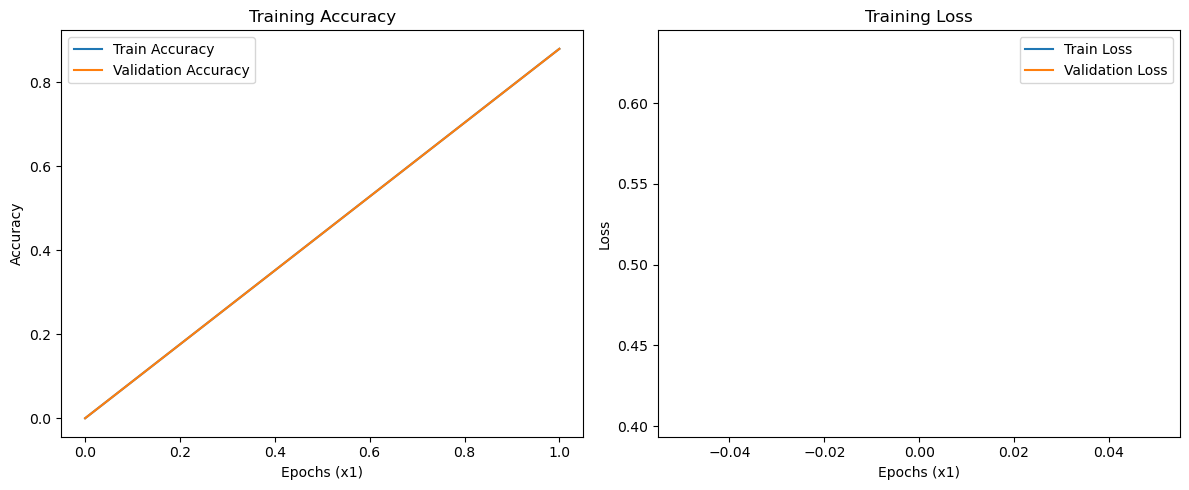

Epoch 1 out of 200
Epoch 2 out of 200
Epoch 3 out of 200
Epoch 4 out of 200
Epoch 5 out of 200
Epoch 6 out of 200
Epoch 7 out of 200
Epoch 8 out of 200
Epoch 9 out of 200
Epoch 10 out of 200
Train Accuracy: 0.935
Validation Accuracy: 0.932
Train Loss: 0.230
Validation Loss: 0.245


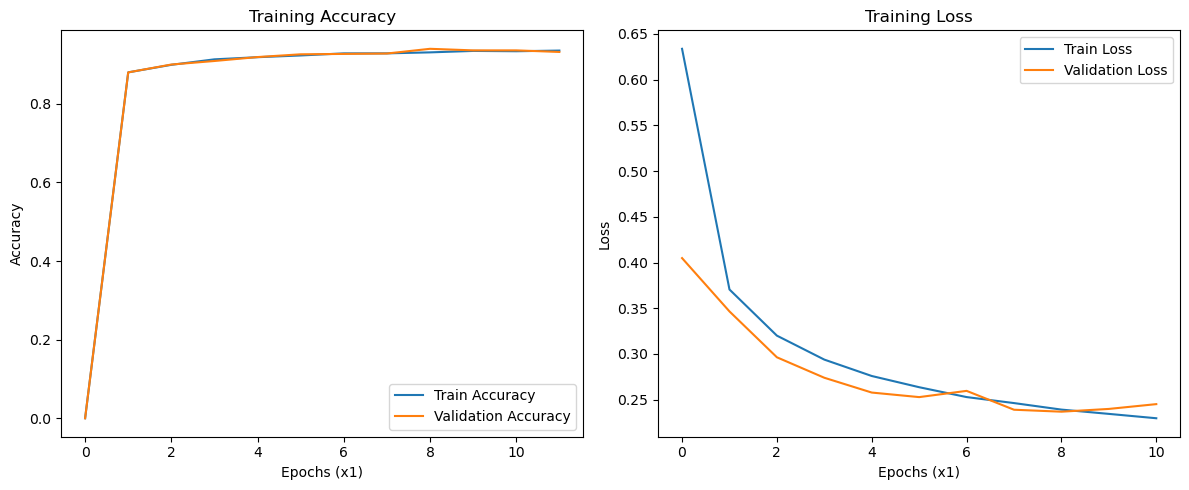

Epoch 11 out of 200
Epoch 12 out of 200
Epoch 13 out of 200
Epoch 14 out of 200
Epoch 15 out of 200
Epoch 16 out of 200
Epoch 17 out of 200
Epoch 18 out of 200
Epoch 19 out of 200
Epoch 20 out of 200
Train Accuracy: 0.940
Validation Accuracy: 0.929
Train Loss: 0.206
Validation Loss: 0.241


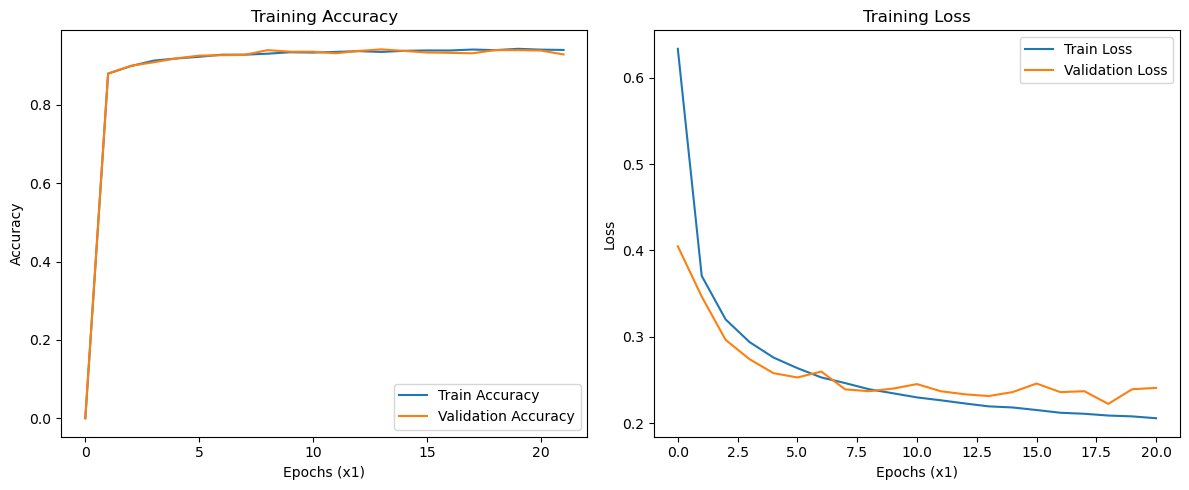

Epoch 21 out of 200
Epoch 22 out of 200
Epoch 23 out of 200
Epoch 24 out of 200
Epoch 25 out of 200
Epoch 26 out of 200
Epoch 27 out of 200
Epoch 28 out of 200
Epoch 29 out of 200
Epoch 30 out of 200
Train Accuracy: 0.944
Validation Accuracy: 0.936
Train Loss: 0.193
Validation Loss: 0.227


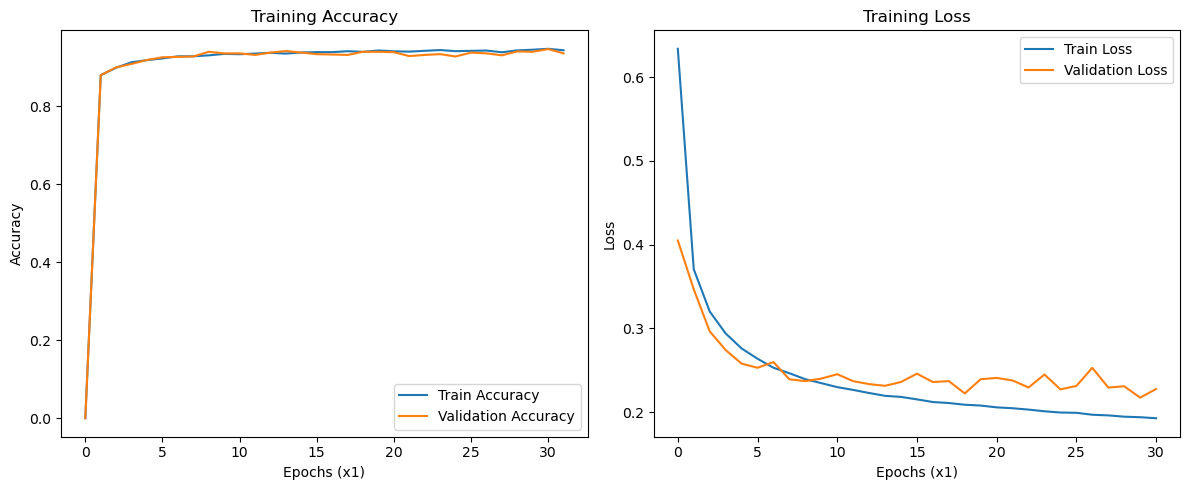

Epoch 31 out of 200
Epoch 32 out of 200
Epoch 33 out of 200
Epoch 34 out of 200
Epoch 35 out of 200
Epoch 36 out of 200
Epoch 37 out of 200
Epoch 38 out of 200
Epoch 39 out of 200
Epoch 40 out of 200
Train Accuracy: 0.947
Validation Accuracy: 0.932
Train Loss: 0.183
Validation Loss: 0.236


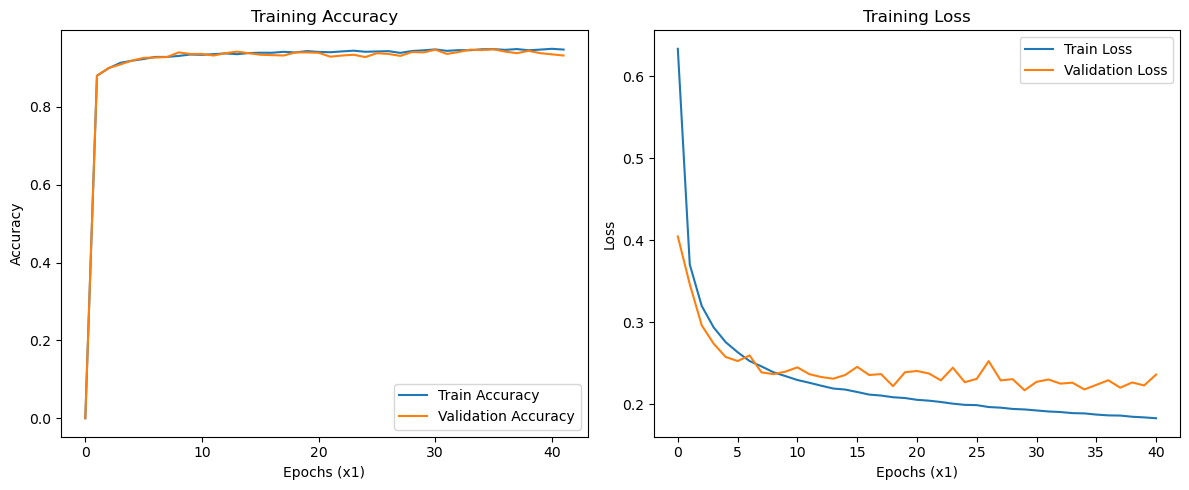

Epoch 41 out of 200
Epoch 42 out of 200
Epoch 43 out of 200
Epoch 44 out of 200
Epoch 45 out of 200
Epoch 46 out of 200
Epoch 47 out of 200
Epoch 48 out of 200
Epoch 49 out of 200
Epoch 50 out of 200
Train Accuracy: 0.950
Validation Accuracy: 0.941
Train Loss: 0.175
Validation Loss: 0.219


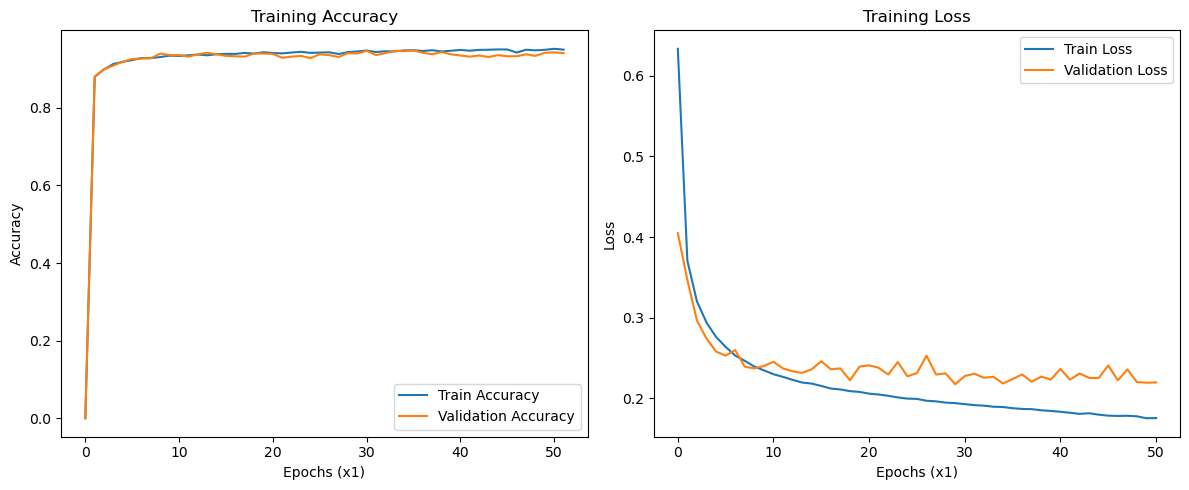

Epoch 51 out of 200
Epoch 52 out of 200
Epoch 53 out of 200
Epoch 54 out of 200
Epoch 55 out of 200
Epoch 56 out of 200
Epoch 57 out of 200
Epoch 58 out of 200
Epoch 59 out of 200
Epoch 60 out of 200
Train Accuracy: 0.949
Validation Accuracy: 0.931
Train Loss: 0.169
Validation Loss: 0.224


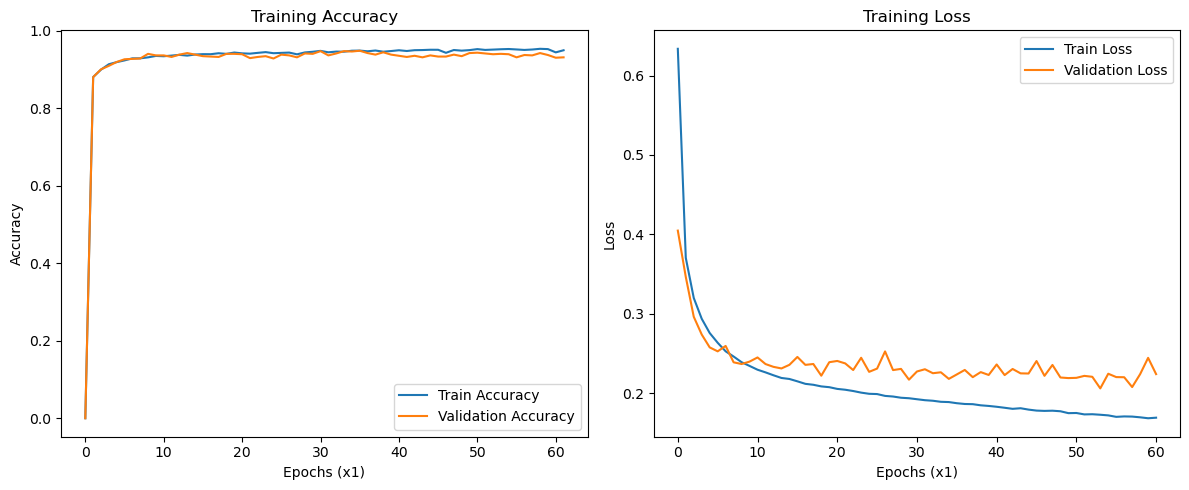

Epoch 61 out of 200
Epoch 62 out of 200
Epoch 63 out of 200
Epoch 64 out of 200
Epoch 65 out of 200
Epoch 66 out of 200
Epoch 67 out of 200
Epoch 68 out of 200
Epoch 69 out of 200
Epoch 70 out of 200
Train Accuracy: 0.954
Validation Accuracy: 0.942
Train Loss: 0.165
Validation Loss: 0.209


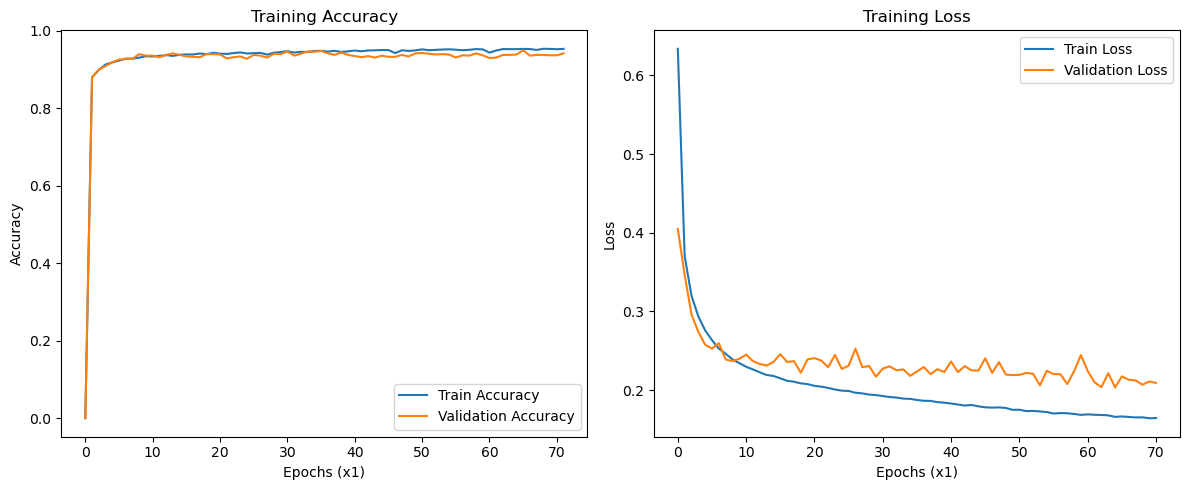

Epoch 71 out of 200
Epoch 72 out of 200
Epoch 73 out of 200
Epoch 74 out of 200
Epoch 75 out of 200
Epoch 76 out of 200
Epoch 77 out of 200
Epoch 78 out of 200
Epoch 79 out of 200
Epoch 80 out of 200
Train Accuracy: 0.954
Validation Accuracy: 0.942
Train Loss: 0.161
Validation Loss: 0.207


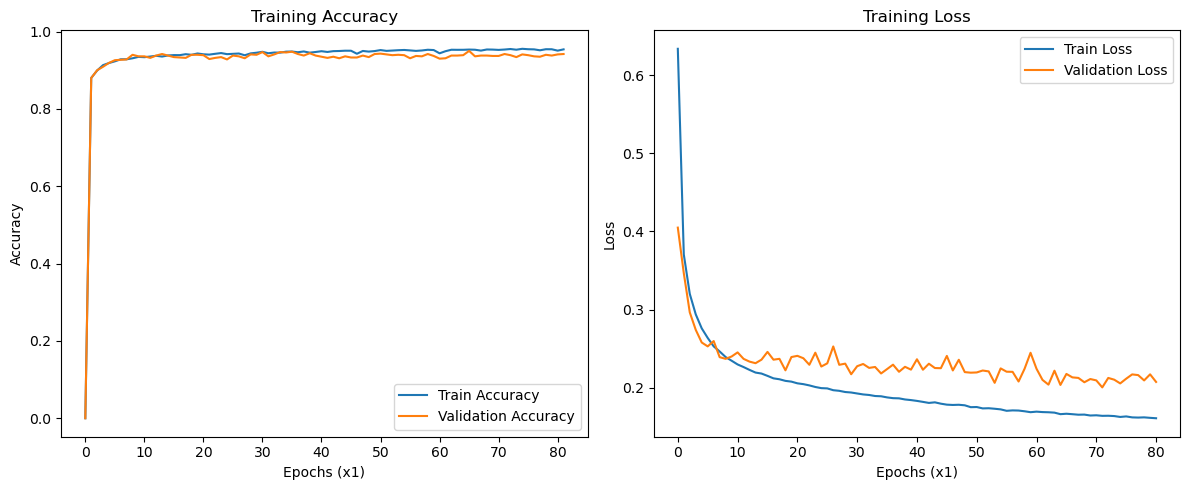

Epoch 81 out of 200
Epoch 82 out of 200
Epoch 83 out of 200
Epoch 84 out of 200
Epoch 85 out of 200
Epoch 86 out of 200
Epoch 87 out of 200
Epoch 88 out of 200
Epoch 89 out of 200
Epoch 90 out of 200
Train Accuracy: 0.956
Validation Accuracy: 0.942
Train Loss: 0.158
Validation Loss: 0.201


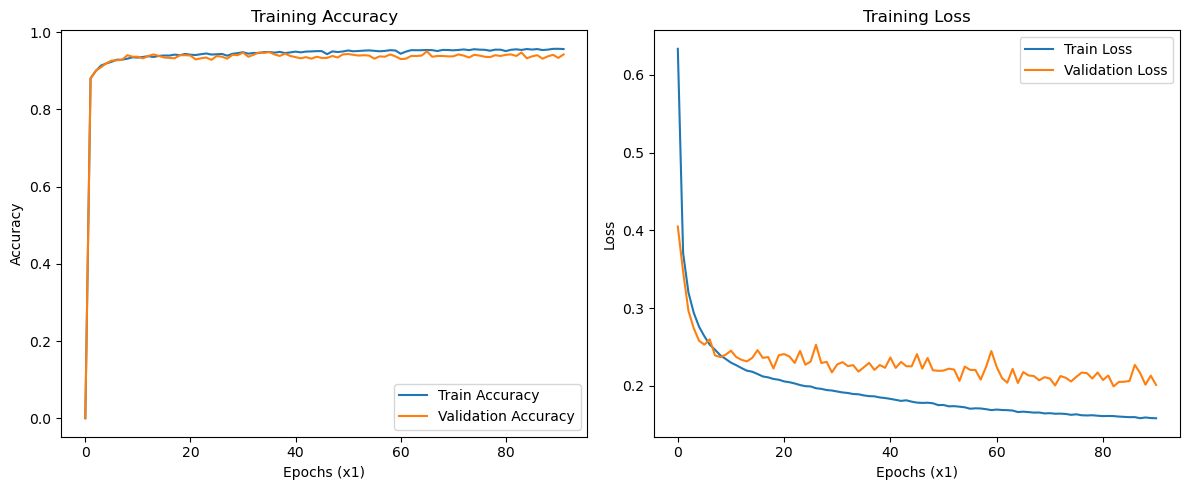

Epoch 91 out of 200
Epoch 92 out of 200
Epoch 93 out of 200
Epoch 94 out of 200
Epoch 95 out of 200
Epoch 96 out of 200
Epoch 97 out of 200
Epoch 98 out of 200
Epoch 99 out of 200
Epoch 100 out of 200
Train Accuracy: 0.957
Validation Accuracy: 0.936
Train Loss: 0.156
Validation Loss: 0.209


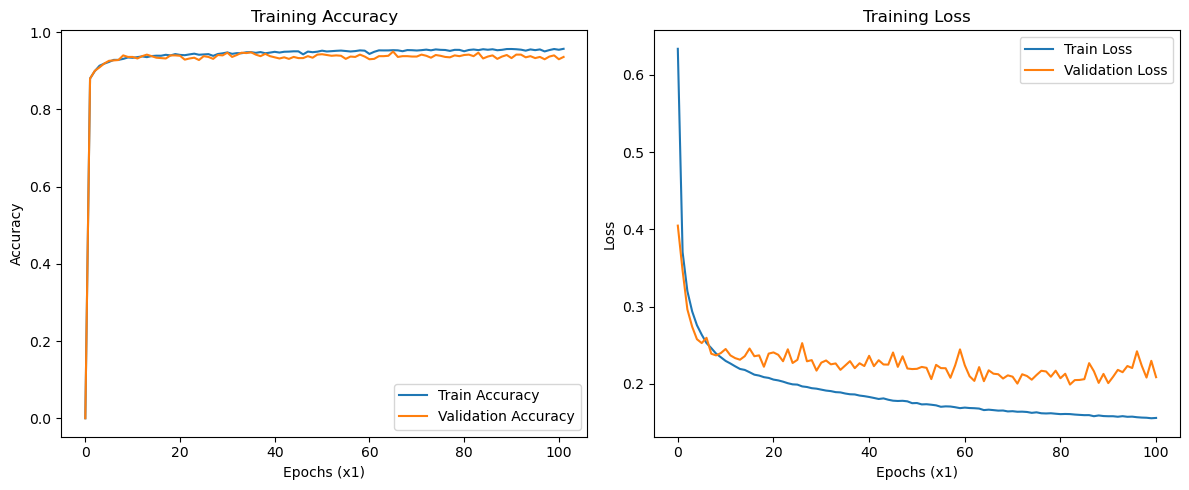

Epoch 101 out of 200
Epoch 102 out of 200
Epoch 103 out of 200
Epoch 104 out of 200
Epoch 105 out of 200
Epoch 106 out of 200
Epoch 107 out of 200
Epoch 108 out of 200
Epoch 109 out of 200
Epoch 110 out of 200
Train Accuracy: 0.956
Validation Accuracy: 0.937
Train Loss: 0.154
Validation Loss: 0.217


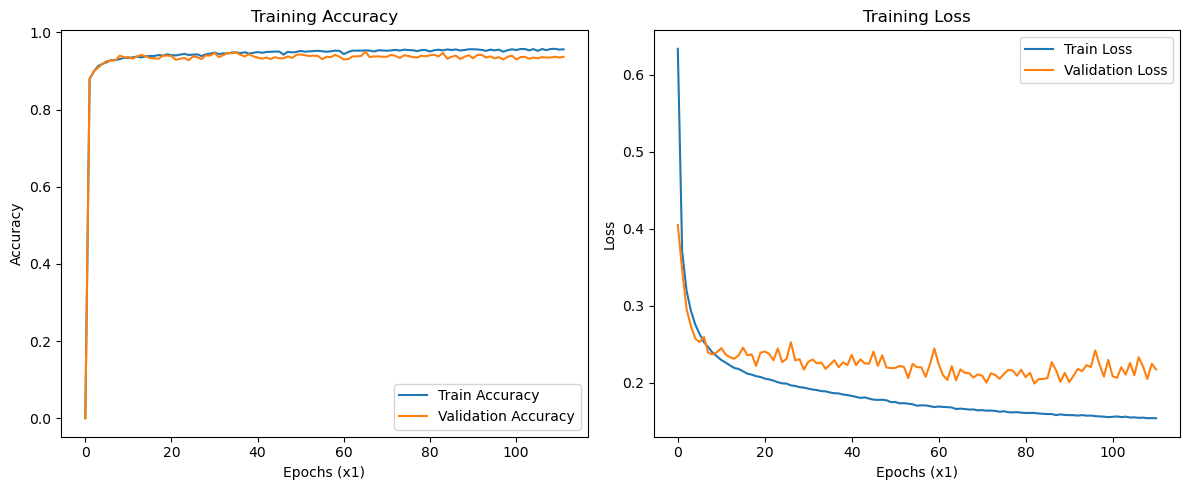

Epoch 111 out of 200
Epoch 112 out of 200
Epoch 113 out of 200
Epoch 114 out of 200
Epoch 115 out of 200
Epoch 116 out of 200
Epoch 117 out of 200
Epoch 118 out of 200
Epoch 119 out of 200
Epoch 120 out of 200
Train Accuracy: 0.957
Validation Accuracy: 0.937
Train Loss: 0.152
Validation Loss: 0.206


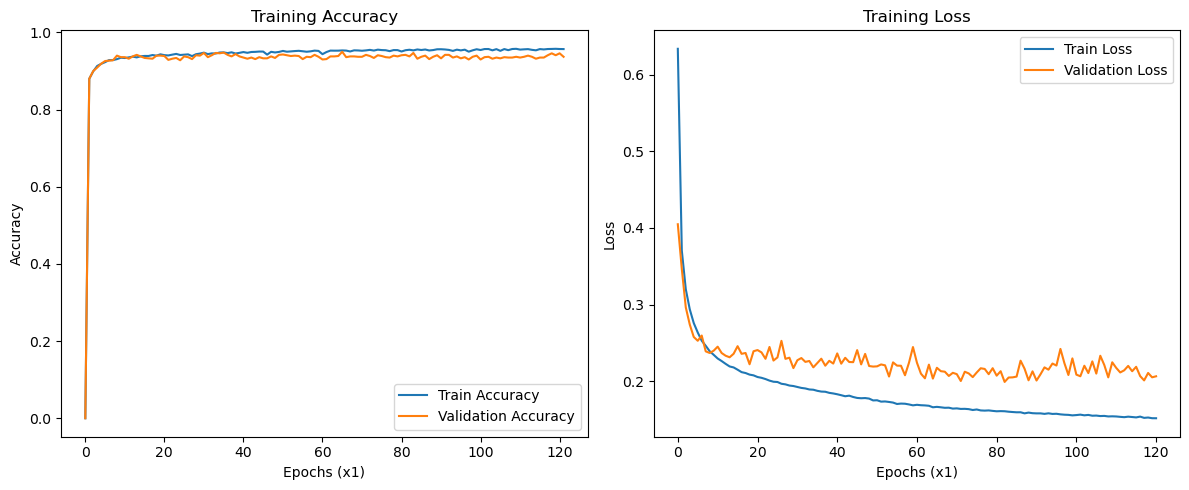

Epoch 121 out of 200
Epoch 122 out of 200
Epoch 123 out of 200
Epoch 124 out of 200
Epoch 125 out of 200
Epoch 126 out of 200
Epoch 127 out of 200
Epoch 128 out of 200
Epoch 129 out of 200
Epoch 130 out of 200
Train Accuracy: 0.957
Validation Accuracy: 0.940
Train Loss: 0.151
Validation Loss: 0.206


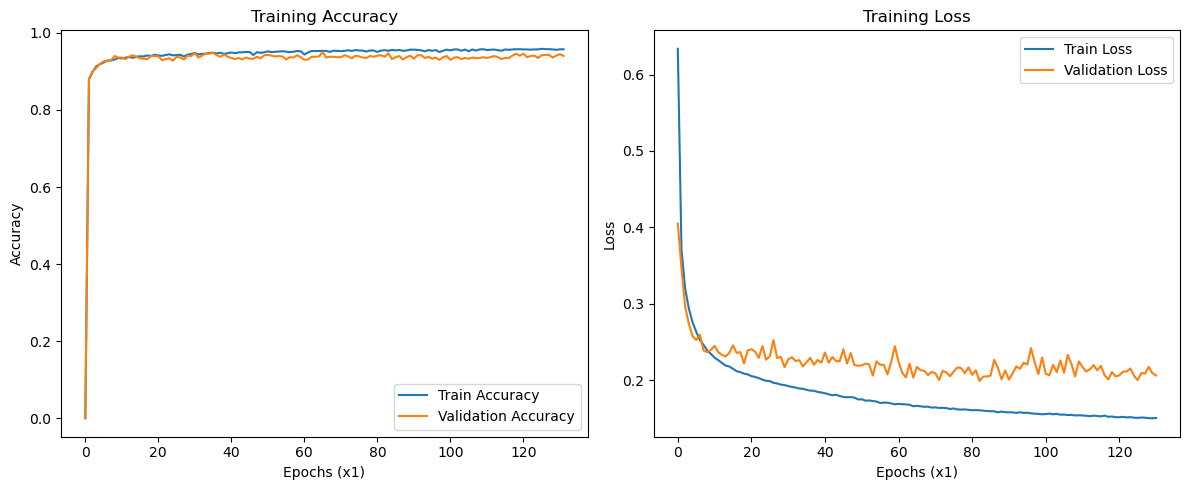

Epoch 131 out of 200
Epoch 132 out of 200
Epoch 133 out of 200
Epoch 134 out of 200
Epoch 135 out of 200
Epoch 136 out of 200
Epoch 137 out of 200
Epoch 138 out of 200
Epoch 139 out of 200
Epoch 140 out of 200
Train Accuracy: 0.955
Validation Accuracy: 0.935
Train Loss: 0.150
Validation Loss: 0.214


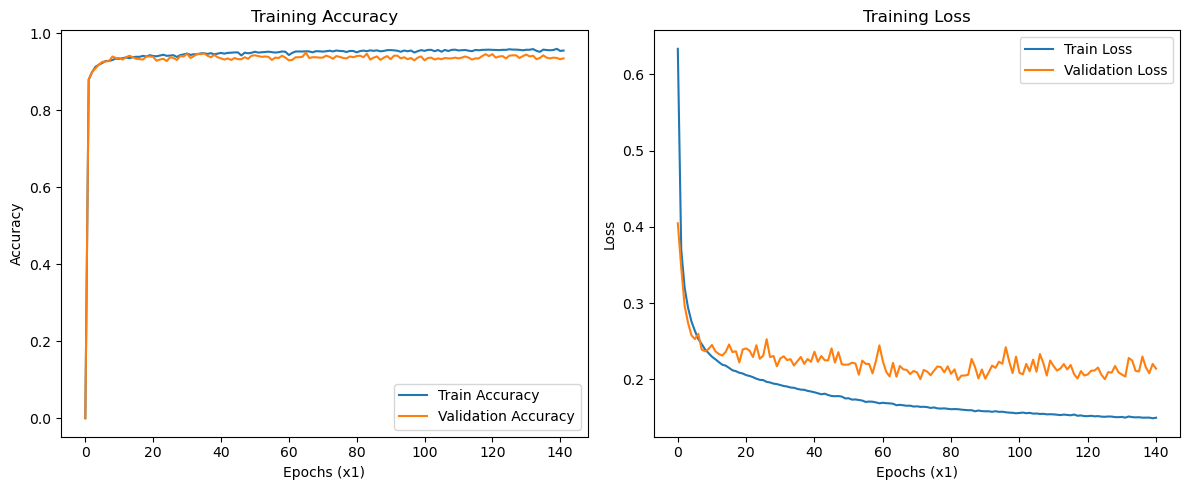

Epoch 141 out of 200
Epoch 142 out of 200
Epoch 143 out of 200
Epoch 144 out of 200
Epoch 145 out of 200
Epoch 146 out of 200
Epoch 147 out of 200
Epoch 148 out of 200
Epoch 149 out of 200
Epoch 150 out of 200
Train Accuracy: 0.959
Validation Accuracy: 0.934
Train Loss: 0.148
Validation Loss: 0.208


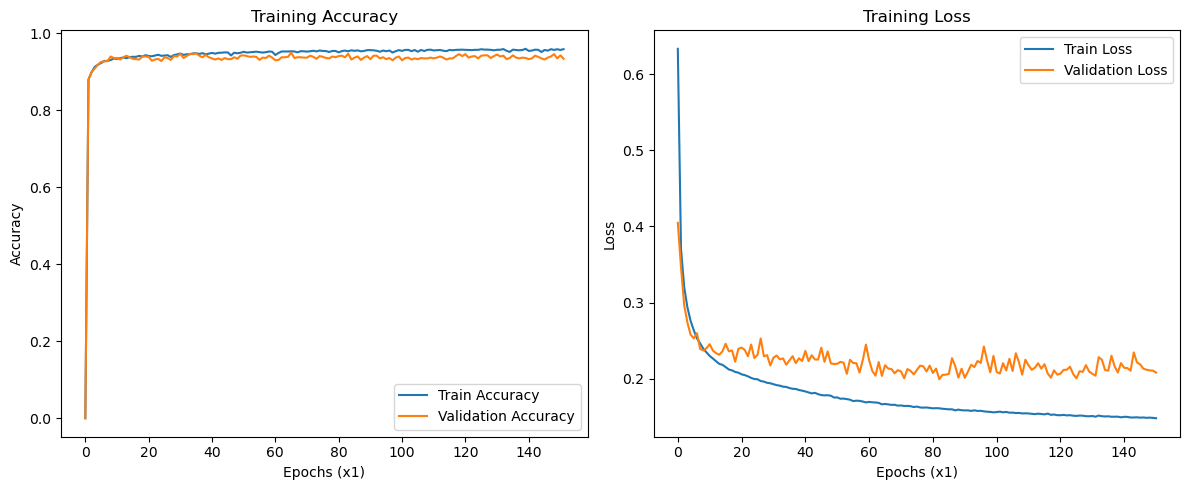

Epoch 151 out of 200
Epoch 152 out of 200
Epoch 153 out of 200
Epoch 154 out of 200
Epoch 155 out of 200
Epoch 156 out of 200
Epoch 157 out of 200
Epoch 158 out of 200
Epoch 159 out of 200
Epoch 160 out of 200
Train Accuracy: 0.954
Validation Accuracy: 0.941
Train Loss: 0.148
Validation Loss: 0.221


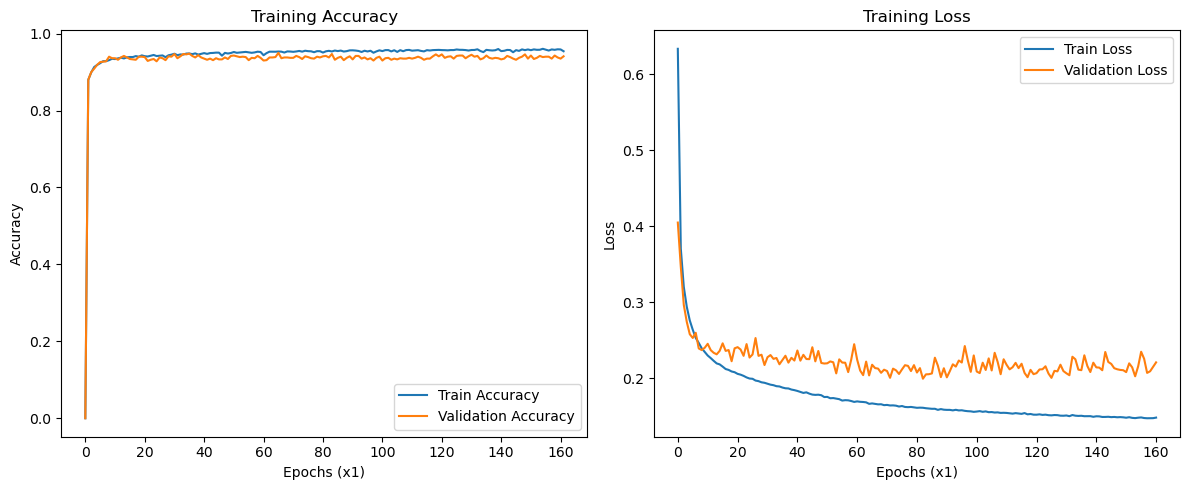

Epoch 161 out of 200
Epoch 162 out of 200
Epoch 163 out of 200
Epoch 164 out of 200
Epoch 165 out of 200
Epoch 166 out of 200
Epoch 167 out of 200
Epoch 168 out of 200
Epoch 169 out of 200
Epoch 170 out of 200
Train Accuracy: 0.956
Validation Accuracy: 0.941
Train Loss: 0.146
Validation Loss: 0.226


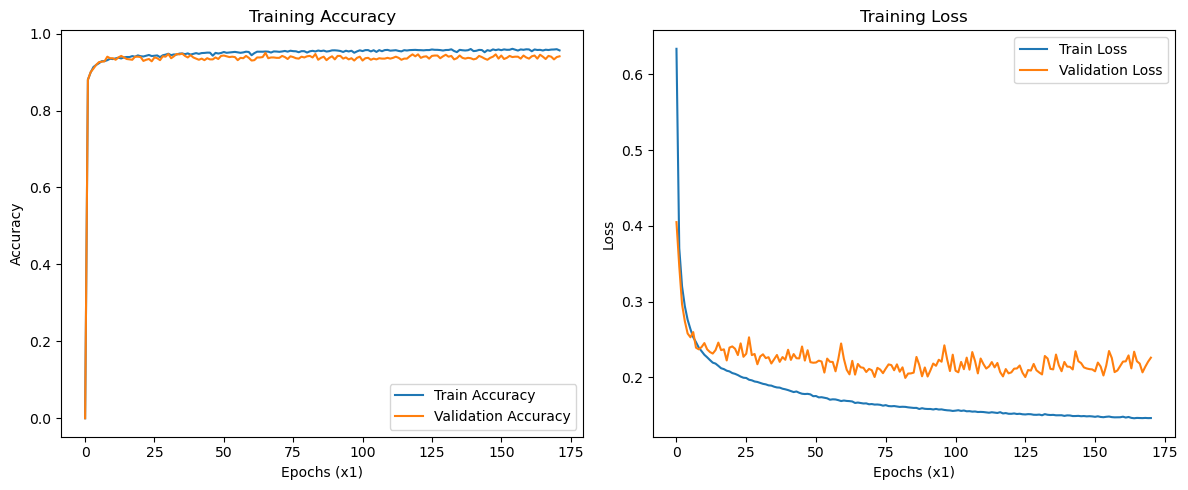

Epoch 171 out of 200
Epoch 172 out of 200
Epoch 173 out of 200
Epoch 174 out of 200
Epoch 175 out of 200
Epoch 176 out of 200
Epoch 177 out of 200
Epoch 178 out of 200
Epoch 179 out of 200
Epoch 180 out of 200
Train Accuracy: 0.960
Validation Accuracy: 0.939
Train Loss: 0.145
Validation Loss: 0.215


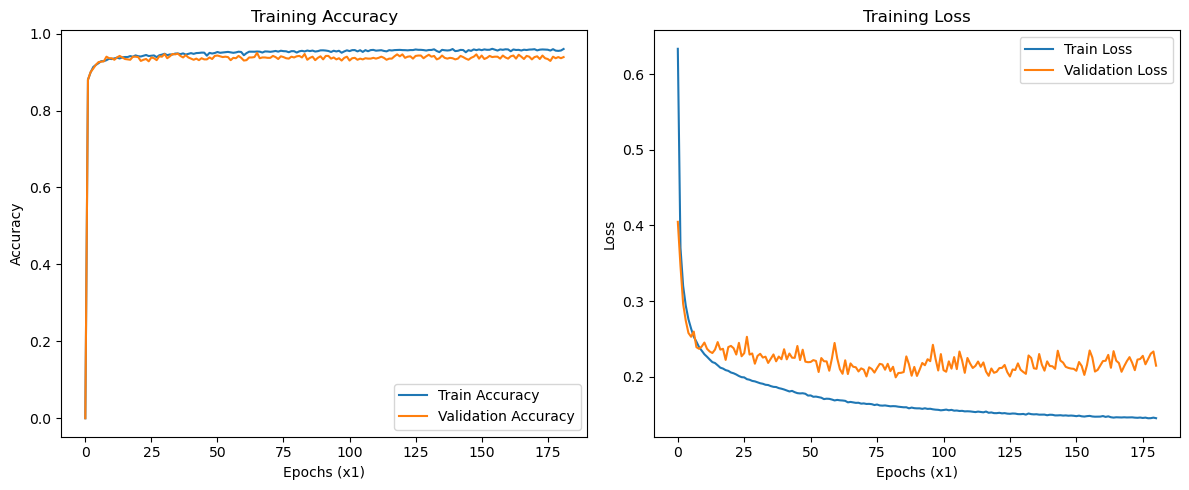

Epoch 181 out of 200
Epoch 182 out of 200
Epoch 183 out of 200
Epoch 184 out of 200
Epoch 185 out of 200
Epoch 186 out of 200
Epoch 187 out of 200
Epoch 188 out of 200
Epoch 189 out of 200
Epoch 190 out of 200
Train Accuracy: 0.958
Validation Accuracy: 0.937
Train Loss: 0.144
Validation Loss: 0.228


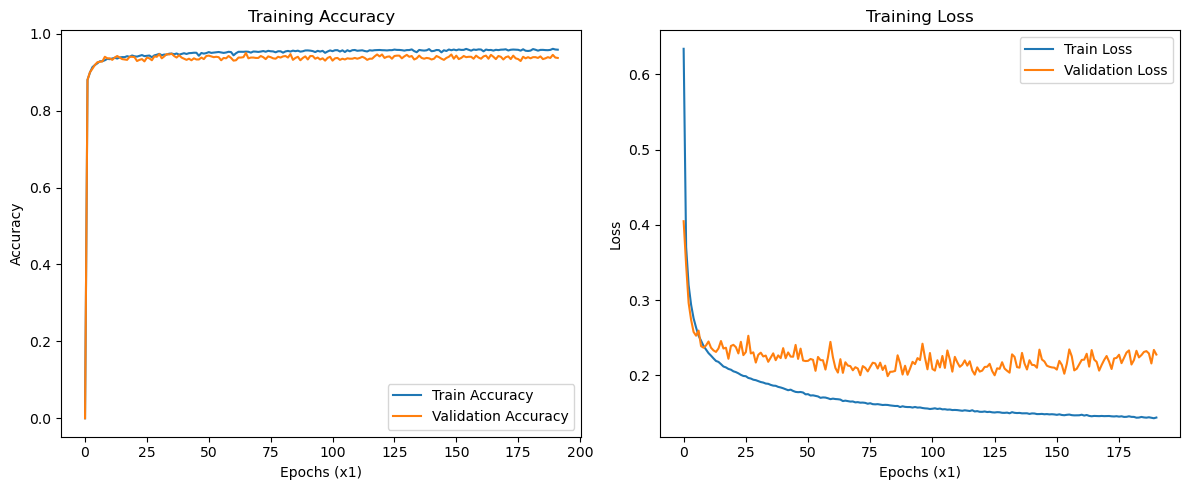

Epoch 191 out of 200
Epoch 192 out of 200
Epoch 193 out of 200
Epoch 194 out of 200
Epoch 195 out of 200
Epoch 196 out of 200
Epoch 197 out of 200
Epoch 198 out of 200
Epoch 199 out of 200
Training completed in 638.15 seconds.


In [20]:
# Perform NN training
W1, b1, W2, b2 = mini_batch_gradient_descent(values_train, labels_train, EPOCHS, ALPHA, BATCHSIZE, values_validation, labels_validation)

In [21]:
def evaluate_model(W1, b1, W2, b2, values, labels):
    _, _, _, A2 = forward_propagation(W1, b1, W2, b2, values)
    predictions = get_predictions(A2)
    accuracy = get_accuracy(predictions, labels)
    loss = cross_entropy_loss(A2, one_hot(labels))

    return accuracy, loss

accuracy_train, loss_train = evaluate_model(W1, b1, W2, b2, values_train, labels_train)
accuracy_validation, loss_validation = evaluate_model(W1, b1, W2, b2, values_validation, labels_validation)
accuracy_test, loss_test = evaluate_model(W1, b1, W2, b2, values_test, labels_test)

print(f"Train Accuracy: {accuracy_train:.3f}")
print(f"Train Loss: {loss_train:.3f}")
print(f"Validation Accuracy: {accuracy_validation:.3f}")
print(f"Validation Loss: {loss_validation:.3f}")
print(f"Test Accuracy: {accuracy_test:.3f}")
print(f"Test Loss: {loss_test:.3f}")


Train Accuracy: 0.958
Train Loss: 0.140
Validation Accuracy: 0.937
Validation Loss: 0.230
Test Accuracy: 0.938
Test Loss: 0.220


In [22]:
def calculate_parameters(W1, b1, W2, b2):
    parameters_count = W1.size + b1.size + W2.size + b2.size
    return parameters_count

parameters_count = calculate_parameters(W1, b1, W2, b2)
print(f"Total Trainable Parameters: {parameters_count}")

Total Trainable Parameters: 7960
